In [ ]:
!pip install parameter-sherpa pandas numpy

In [149]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import sherpa
%display typeset

In [3]:
CA_POP = 14810000

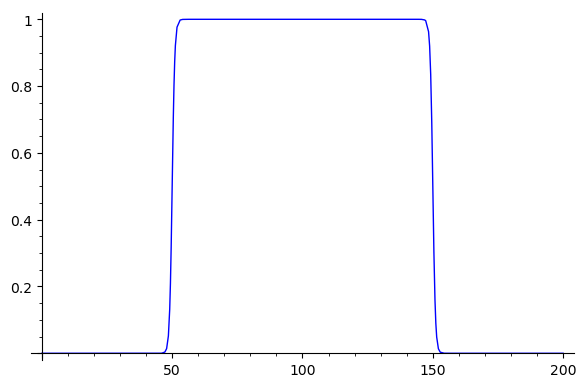

In [76]:
eq = ((1 + np.tanh(x - 50)) / 2) * ((1 - np.tanh(x - 150)) / 2)
plot(eq, (x,0,200))

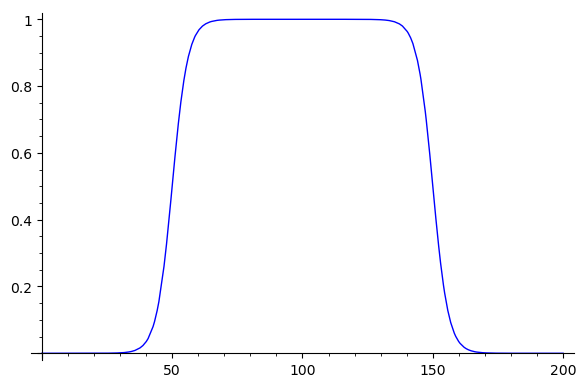

In [109]:
eq = ((1 + np.tanh((x - 50)/6)) / 2) * ((1 - np.tanh((x - 150)/6)) / 2)
plot(eq, (x,0,200))

In [180]:
def model(t, y, params):
    S, E, I, A, H, R = y
    chi, phi, beta, rho, delta, gamma, alpha, mu, p, q, r = params
    lamb = beta * (I + A)
    
    #if (t < q or t > q + r):
    #    chi = 0
        
    # Turns on Quarantine on day q and off on day q+r
    chi *= ((1 + np.tanh((t - q)/15)) / 2) * ((1 - np.tanh((t - (q+r))/15)) / 2)
    
    return [
        -lamb * ((1 - chi) * S),                   # 0 dS/dt
        lamb * ((1 - chi) * S) - alpha * E,        # 1 dE/dt
        (1 - p) * alpha * E - delta * I - phi * I, # 2 dI/dt
        p * alpha * E - gamma * A,                 # 3 dA/dt
        phi * I - (rho + mu) * H,                  # 4 dH/dt
        delta * I + rho * H + gamma * A,           # 5 dR/dt
    ]

def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim

O = ode_solver()
O.function = model
O.algorithm = 'rk4'
inits = [.99, 0, 0, 1e-5, 0, 0]

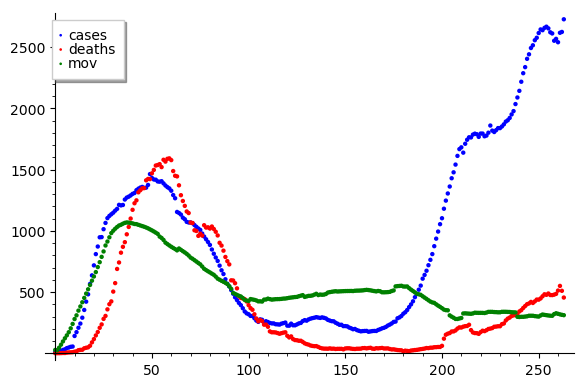

In [144]:
dfCA = pd.read_pickle("data.pkl")
LEN = len(dfCA)
a = list_plot(dfCA["cases"],     color='blue',  legend_label="cases")
b = list_plot(dfCA["deaths"]*10, color='red',   legend_label="deaths")
c = list_plot(dfCA["mov"]*20,    color='green', legend_label="mov")
show(a+b+c)

In [145]:
def plot_results(result):
    pars = [result[n] for n in PARAM]
    phi = result['phi']
    mu = result['mu']
    t0 = result['t0']
    O.ode_solve([0, t0+LEN], inits, num_points=t0+LEN, params=pars)
    sim = get_sim_array(O.solution) * CA_POP
    i   = list_plot(phi*sim[:LEN+t0,2],color='red',legend_label='New. cases', plotjoined=True)
    #h   = list_plot(sim[:LEN+t0,4],color='purple', legend_label='New. Deaths', plotjoined=True)
    cc  = list_plot(list(zip(range(t0,LEN+t0),dfCA.cases)), color='black',legend_label='cases (obs)')
    #cd  = list_plot(list(zip(range(t0,LEN+t0),dfCA.deaths)), color='orange',legend_label='deaths(obs)')
    #show(i + h + cc + cd)
    show(i + cc)

In [155]:
PARAM = ['chi', 'phi', 'beta', 'rho', 'delta', 'gamma', 'alpha', 'mu', 'p', 'q', 'r']
parameters = [
    sherpa.Continuous(name='alpha',range=[0.19,0.22]), #
    sherpa.Continuous(name='beta' ,range=[0.57,0.63]), #
    sherpa.Continuous(name='chi'  ,range=[0.8,0.999]), #
    sherpa.Continuous(name='delta',range=[0.6,0.8]),
    sherpa.Continuous(name='gamma',range=[0.01,0.04]),
    sherpa.Continuous(name='mu'   ,range=[0.04,0.06]),
    sherpa.Continuous(name='p'    ,range=[0.4,0.7]),
    sherpa.Continuous(name='phi'  ,range=[0.01,0.03]), #
    sherpa.Discrete  (name='q'    ,range=[40,60]),
    sherpa.Discrete  (name='r'    ,range=[170,200]), #
    sherpa.Continuous(name='rho'  ,range=[0.6,7]),
    sherpa.Discrete  (name='t0'   ,range=[10,30]), #
]

TRIALS = 100
algorithm = sherpa.algorithms.RandomSearch(max_num_trials=TRIALS)

study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)

trial = study.get_suggestion()
print(trial.parameters)

{'alpha': 0.21354036740325785, 'beta': 0.6273088427039696, 'chi': 0.8620446501307708, 'delta': 0.7590223432501022, 'gamma': 0.023681598635060856, 'mu': 0.042318068686063304, 'p': 0.41251150105187834, 'phi': 0.023974162347433887, 'q': 58, 'r': 199, 'rho': 2.642086414757266, 't0': 18}


{'Trial-ID': 6, 'Iteration': 1, 'alpha': 0.2160290313290913, 'beta': 0.6205970507086923, 'chi': 0.9384803115455747, 'delta': 0.7534265105148014, 'gamma': 0.033427251944866274, 'mu': 0.0534110805081093, 'p': 0.5479805196995566, 'phi': 0.019136697518315444, 'q': 50, 'r': 182, 'rho': 1.7123427960371749, 't0': 18, 'Objective': 218742.64957932223}


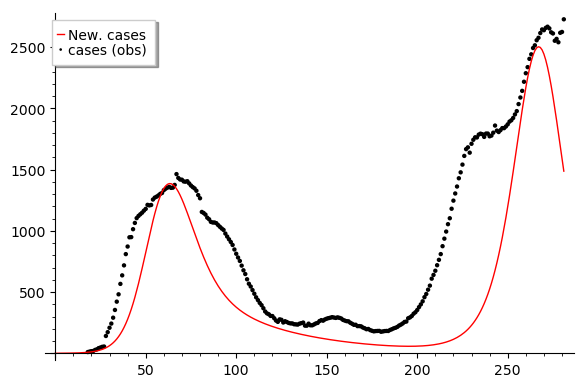

In [166]:
i = 0

for trial in study:
    
    if (i % 10 == 0):
        print(f"{i} ", end="")
    i += 1
    
    t0 = trial.parameters['t0']
    pars = [trial.parameters[n] for n in PARAM]

    O.ode_solve([0, t0+LEN], inits, num_points=t0+LEN, params=pars)
    sim = get_sim_array(O.solution)
    
    I = sim[t0 : t0 + LEN, 2] * CA_POP
    H = sim[t0 : t0 + LEN, 4] * CA_POP
        
    phi = trial.parameters["phi"]
    mu = trial.parameters["mu"]
    
    lic = list(dfCA.cases)
    lid = list(dfCA.deaths)
    
    loss = ( sum((dfCA.cases-phi*I)**2) + sum((dfCA.deaths-mu*H)**2) )/(2*LEN)
    #loss = (lic[60] - phi*I[60]) ** 2 + (lic[150] - phi*I[150]) ** 2 + (lic[250] - phi*I[250]) ** 2
    
    study.add_observation(trial=trial, objective=loss)
    study.finalize(trial)

clear_output(wait=True)    

res = study.get_best_result()
print(res)
plot_results(res)

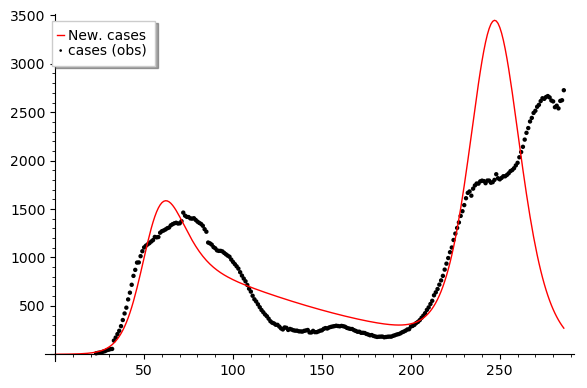

In [186]:
resu = {
    'alpha': 0.19,
    'beta':  0.6,
    'chi':   0.9,
    'delta': 0.75,
    'gamma': 0.03,
    'mu':    0.05, #
    'p':     0.55,
    'phi':   0.03,
    'q':     50,
    'r':     172,
    'rho':   1.7, #
    't0':    23}

plot_results(resu)